In [13]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, Xception, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize, LabelEncoder
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = tf.keras.preprocessing.image.load_img(os.path.join(folder, filename), target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img)
    return np.array(images)

def load_labels_from_csv(file_path):
    df = pd.read_csv(file_path)
    return df['Risk of macular edema '].values  # Use the correct column name here


In [3]:
# Load image from the dataset
train_data_dir = '1. Original Images/a. Training Set'
test_data_dir = '1. Original Images/b. Testing Set'
train_csv_path = '2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
test_csv_path = '2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'

In [4]:
# Read train and test CSV files with specific columns
train_df = pd.read_csv(train_csv_path, usecols=['Image name', 'Risk of macular edema '])
test_df = pd.read_csv(test_csv_path, usecols=['Image name', 'Risk of macular edema '])

# Convert 'Risk of macular edema' column to string type
train_df['Risk of macular edema '] = train_df['Risk of macular edema '].astype(str)
test_df['Risk of macular edema '] = test_df['Risk of macular edema '].astype(str)

train_df['Image name'] = train_df['Image name'].astype(str) + '.jpg'
test_df['Image name'] = test_df['Image name'].astype(str) + '.jpg'


In [5]:
# Define function to read images and labels from dataset
def read_images_and_labels(data_path, annotation_df):
    data = []
    for index, row in annotation_df.iterrows():
        image_name = row['Image name']
        label = row['Risk of macular edema ']
        image_path = os.path.join(data_path, image_name)
        image = cv2.imread(image_path)  # assuming in OpenCV compatible format
        image = cv2.resize(image, (224, 224))
        data.append([image, label])
    return data



In [6]:
# Read images and labels using DataFrames
train_data = read_images_and_labels(train_data_dir, train_df)
test_data = read_images_and_labels(test_data_dir, test_df)

# Combine data
data = train_data + test_data

print("Data reading done")


Data reading done


In [7]:
# Preprocess the data
np.random.shuffle(data)
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)



In [8]:
# Stratified splitting for train-test split
n_splits = 1
test_size = 0.2
stratified_split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=43)

for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



In [9]:
# Further split training data into training and validation sets
for train_index, val_index in stratified_split.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[val_index]
    y_train, y_val = y_train[train_index], y_train[val_index]

# One-hot encode the labels
train_labels = to_categorical(y_train, num_classes=3)
val_labels = to_categorical(y_val, num_classes=3)
test_labels_one_hot = to_categorical(y_test, num_classes=3)

print("Data preprocessing done")


Data preprocessing done


In [10]:
# Check classwise distribution in train, test, and validation sets
unique_classes = np.unique(np.concatenate((y_train, y_test, y_val)))
for class_label in unique_classes:
    print(f"Class {class_label}:")
    print(f"Train: {np.sum(y_train == class_label)} images")
    print(f"Test: {np.sum(y_test == class_label)} images")
    print(f"Validation: {np.sum(y_val == class_label)} images")
    print('.........')

Class 0:
Train: 141 images
Test: 45 images
Validation: 36 images
.........
Class 1:
Train: 33 images
Test: 10 images
Validation: 8 images
.........
Class 2:
Train: 155 images
Test: 49 images
Validation: 39 images
.........


In [14]:
# Define ResNet50 model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_resnet.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)

for layer in base_model_resnet.layers:
    layer.trainable = False

model_resnet.compile(optimizer=Adam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
# Train the ResNet50 model
history_resnet = model_resnet.fit(X_train, train_labels, validation_data=(X_val, val_labels), epochs=30, batch_size=10)


Epoch 1/30
33/33 [==============================] - 69s 2s/step - loss: 42.1956 - accuracy: 0.5957 - val_loss: 13.9126 - val_accuracy: 0.7470
Epoch 2/30
33/33 [==============================] - 54s 2s/step - loss: 6.6465 - accuracy: 0.8389 - val_loss: 12.4841 - val_accuracy: 0.6988
Epoch 3/30
33/33 [==============================] - 56s 2s/step - loss: 3.6957 - accuracy: 0.8845 - val_loss: 18.4495 - val_accuracy: 0.7229
Epoch 4/30
33/33 [==============================] - 59s 2s/step - loss: 2.3766 - accuracy: 0.9240 - val_loss: 21.6831 - val_accuracy: 0.7108
Epoch 5/30
33/33 [==============================] - 53s 2s/step - loss: 2.0419 - accuracy: 0.9392 - val_loss: 14.0866 - val_accuracy: 0.7349
Epoch 6/30
33/33 [==============================] - 53s 2s/step - loss: 1.7302 - accuracy: 0.9483 - val_loss: 13.9078 - val_accuracy: 0.6747
Epoch 7/30
33/33 [==============================] - 54s 2s/step - loss: 3.9116 - accuracy: 0.8815 - val_loss: 17.5383 - val_accuracy: 0.6506
Epoch 8/30
3

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_resnet.evaluate(X_test, test_labels_one_hot)
print(f"ResNet50 Test Accuracy: {test_accuracy * 100:.2f}%")


4/4 [==============================] - 6s 1s/step - loss: 19.5351 - accuracy: 0.7981
ResNet50 Test Accuracy: 79.81%


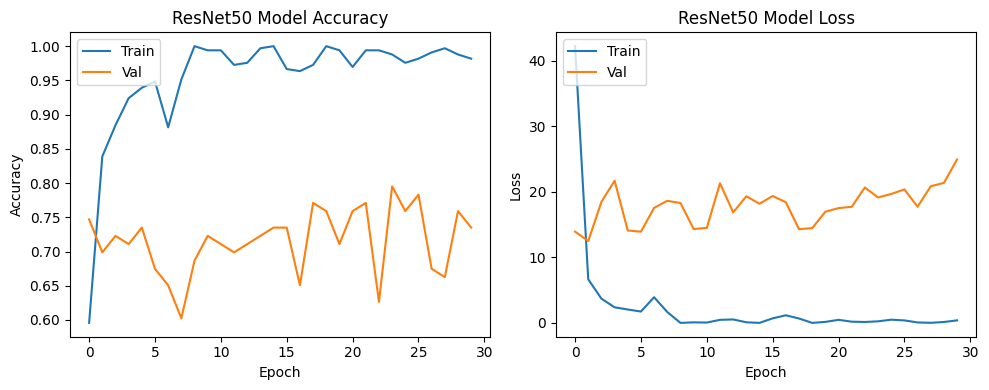

In [17]:
def plot_history(history, title):
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot history for ResNet50
plot_history(history_resnet, "ResNet50")


4/4 [==============================] - 8s 2s/step


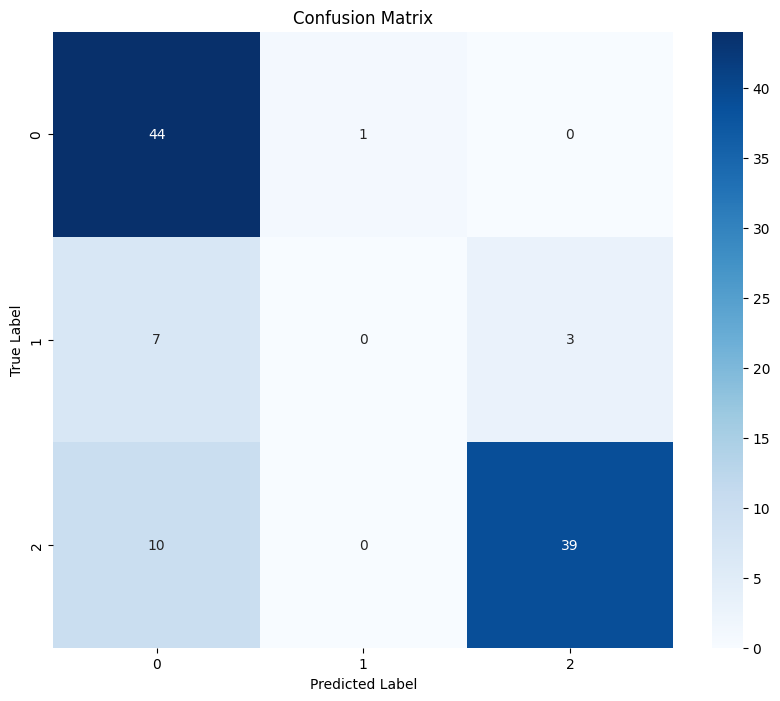

              precision    recall  f1-score   support

       DME 0       0.72      0.98      0.83        45
       DME 1       0.00      0.00      0.00        10
       DME 2       0.93      0.80      0.86        49

    accuracy                           0.80       104
   macro avg       0.55      0.59      0.56       104
weighted avg       0.75      0.80      0.76       104



In [19]:
def evaluate_model(model, X_test, y_test, class_names):
    # Predict the test set results
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert one-hot encoded labels back to categorical labels
    y_test_classes = np.argmax(y_test, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Generate classification report
    report = classification_report(y_test_classes, y_pred_classes, target_names=class_names)

    # Print the classification report
    print(report)

# Evaluate ResNet50 model
class_names = ['DME 0', 'DME 1', 'DME 2']
evaluate_model(model_resnet, X_test, test_labels_one_hot, class_names)
